# Aging Risk Assessment: predictive modeling

In [1]:
import polars as pl
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, metrics, cv, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import statsmodels.api as sm
from statsmodels.formula.api import ols, quantreg
import scipy.stats as stats
import scikit_posthocs as sp

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

Here we composing catboost models for the most fittest prediction of `aging_outcome`.

As we examined in `data exploration.ipynb` the target variable has equal distribution and fit both ordinal and nominal scales:

![](target_variable_distribution.svg)

And also that numeral varibles have none meaningful correlations with each other:

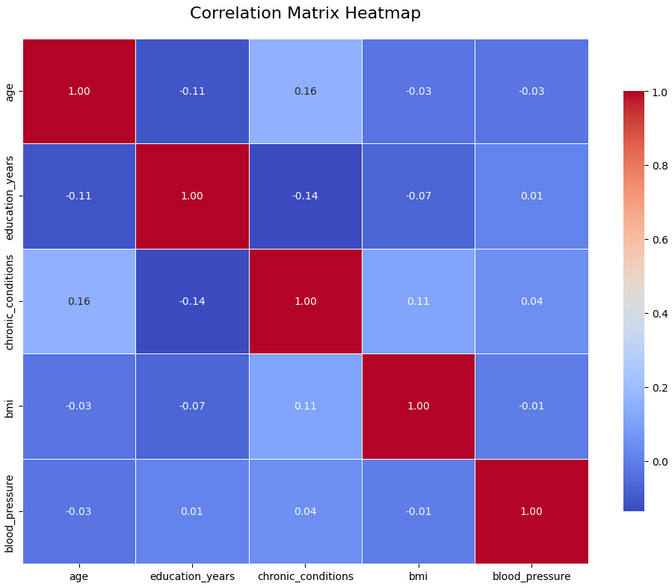

In order to examine additional relationships we can directly use catboosting models to examine variable importance in predicting the target. That will give us both measure of importance and prediction model. The catboost is used here because of its fluid categorical columns handling and ani-overfit measures built in. We will try to fit classical `CatBoostClassifier` model. 

Directly after that we will examine causality between target and predictors

In [2]:
df = pl.read_csv('data/Aging_prediction_dataset.csv')
df

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [58]:
replacement_ls = {'Healthy':1, 'At-risk':2,  'Frail':3}
df = df.with_columns(
    pl.col("aging_outcome").replace(replacement_ls).alias("aging_outcome_int")
)
y = df.to_pandas()['aging_outcome_int']
y

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [53]:
X_train, X_test, y_train, y_test  = train_test_split(df.drop('aging_outcome').to_pandas(), y, test_size=0.33, random_state=42, stratify=y)

In [46]:
train_pool = Pool(X_train, y_train, cat_features=['gender', 'income_level', 'physical_activity', 'smoking_status', 'diet_quality', 'alcohol_consumption', 'social_engagement'])
test_pool = Pool(X_test, y_test, cat_features=['gender', 'income_level', 'physical_activity', 'smoking_status', 'diet_quality', 'alcohol_consumption', 'social_engagement'])

# Catboost `CatBoostClassifier` modeling

In [26]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True
    )


grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth':[2, 5, 7],
    'l2_leaf_reg': [1, 4, 6],
    'logging_level':['Silent'],
    #'eval_metric': ['Accuracy', 'AUC', 'F1']
}

def grid_search_model(train_pool, **kwargs):
    model = CatBoostClassifier(
        iterations=1500,
        eval_metric='AUC:hints=skip_train~false',
        **kwargs
    )

    return model.grid_search(
        grid,
        train_pool,
        verbose=0,
        shuffle=False,
        plot=True
    )

In [29]:
grid_search = grid_search_model(train_pool,  task_type='CPU')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
grid_search['params']

{'depth': 5, 'logging_level': 'Silent', 'learning_rate': 0.1, 'l2_leaf_reg': 1}

## grid search results 
As we can see AUC metric shows us the best fit at the parameters:
```python
{'depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 1}
```

with nearly perfect fit in 0.99. It may indicate overfitting and that is a limitation of the study, however the model will display the importance correctly

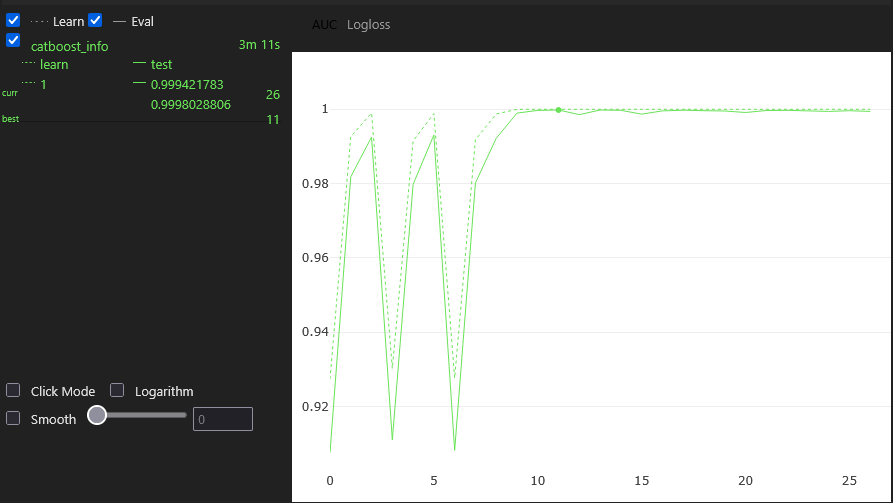

In [30]:
params = {
    'eval_metric': 'F1',
    'iterations': 500,
    'depth': 5, 
    'learning_rate': 0.1,
    'l2_leaf_reg': 1,
    'task_type': 'CPU'
}
model = fit_model(train_pool, test_pool, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8090589	test: 0.8034001	best: 0.8034001 (0)	total: 7.49ms	remaining: 3.74s
100:	learn: 0.9926437	test: 0.9795545	best: 0.9804878 (98)	total: 277ms	remaining: 1.09s
200:	learn: 0.9992521	test: 0.9933049	best: 0.9933049 (194)	total: 546ms	remaining: 812ms
300:	learn: 1.0000000	test: 0.9957473	best: 0.9960522 (293)	total: 806ms	remaining: 533ms
400:	learn: 1.0000000	test: 0.9972653	best: 0.9972653 (360)	total: 1.08s	remaining: 267ms
499:	learn: 1.0000000	test: 0.9972653	best: 0.9978730 (464)	total: 1.35s	remaining: 0us

bestTest = 0.9978729869
bestIteration = 464

Shrink model to first 465 iterations.


## fitting results

In order to correctly evaluate fitting in the final model we opted to F1 score. The result shows nearly perfetc fit with 0.99

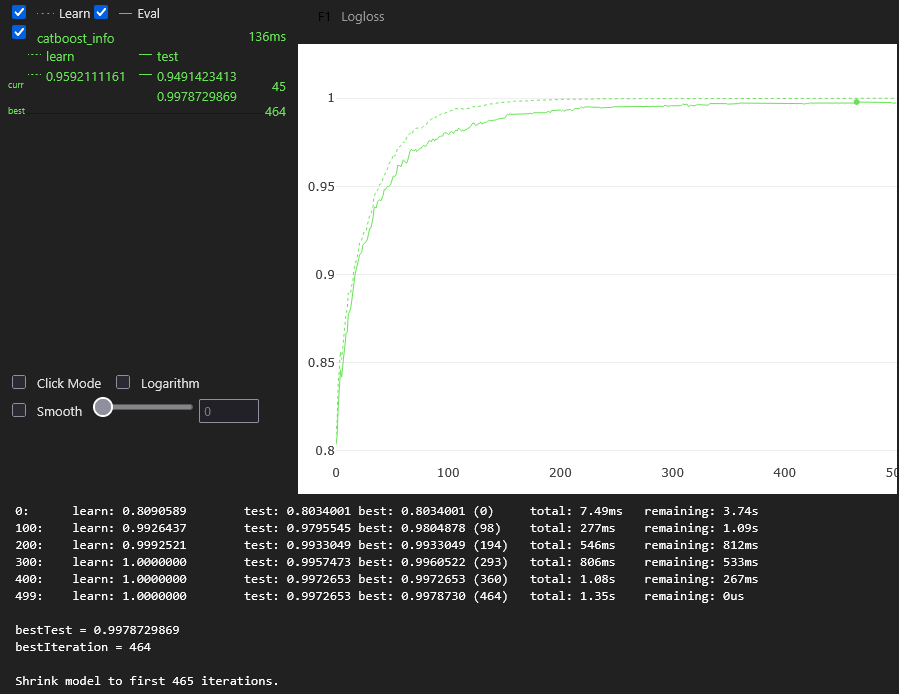

## feature importance 

As we can see the most important factors are (above 10) `memory_score`, `education_years`, `chronic_conditions` and `physical_activity`. And the least important are `gemder`, `alcohol_consumption`, `blood_pressure`, and `income_level`

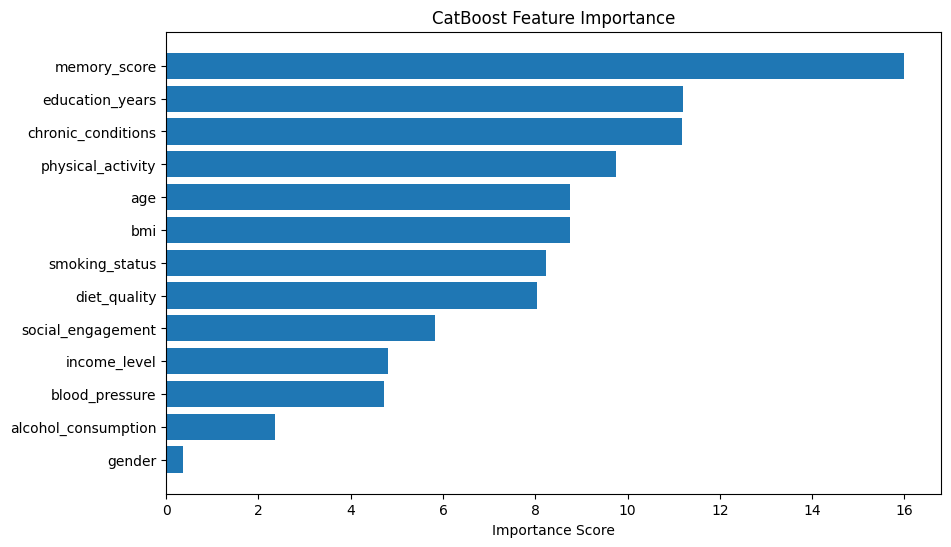

In [31]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis() 
plt.show()   

# Explanatory analysis

Let us fitst examine the differences in `aging_outcome` for different memory scores. In order to do that we will employ ANOVA test. Before that we need to assess the distributions

In [3]:
df.group_by('aging_outcome').agg(pl.col('memory_score').mean().alias('memory score mean'))

Loading ITables v2.5.2 from the init_notebook_mode cell... (need help?)


In [ ]:
categories = ['Healthy', 'At-risk', 'Frail']
aging_outcome_w_ms_df = df[['aging_outcome', 'aging_outcome_int', 'memory_score']].to_pandas()
aging_outcome_w_ms_df['aging_outcome_cat'] = pd.Categorical(
    df['aging_outcome'], 
    categories=['Healthy', 'Frail', 'At-risk'],
    ordered=False
)
aging_outcome_w_ms_df

In [68]:
df[['aging_outcome', 'aging_outcome_int']].unique()

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


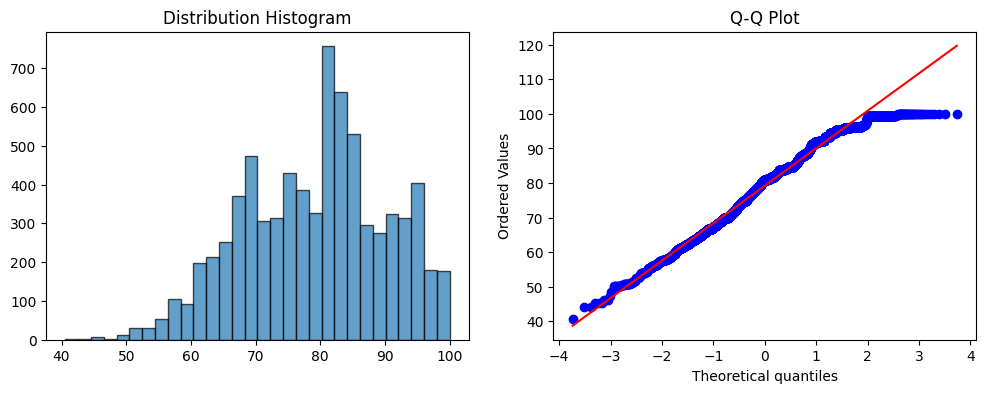

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(aging_outcome_w_ms_df['memory_score'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distributo Histogram')
stats.probplot(aging_outcome_w_ms_df['memory_score'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
plt.show()

Healthy
Kolmogorov-Smirnov test: statistic=0.1306, p-value=0.0000


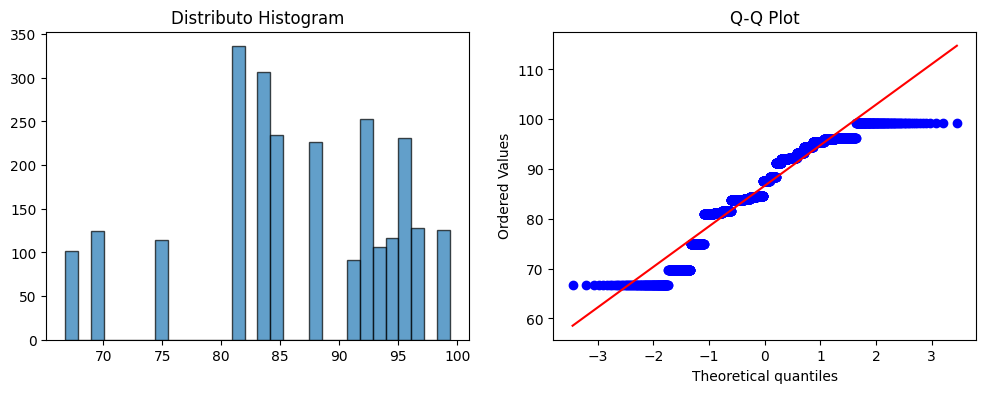

At-risk
Kolmogorov-Smirnov test: statistic=0.0749, p-value=0.0000


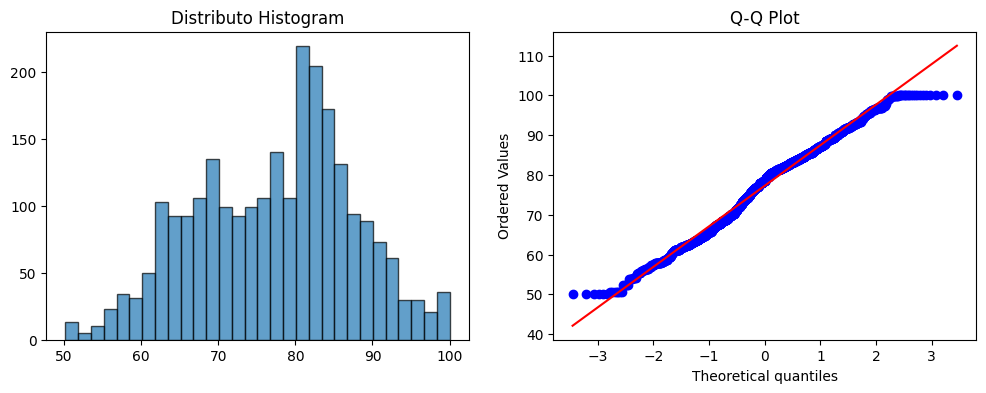

Frail
Kolmogorov-Smirnov test: statistic=0.0186, p-value=0.3483


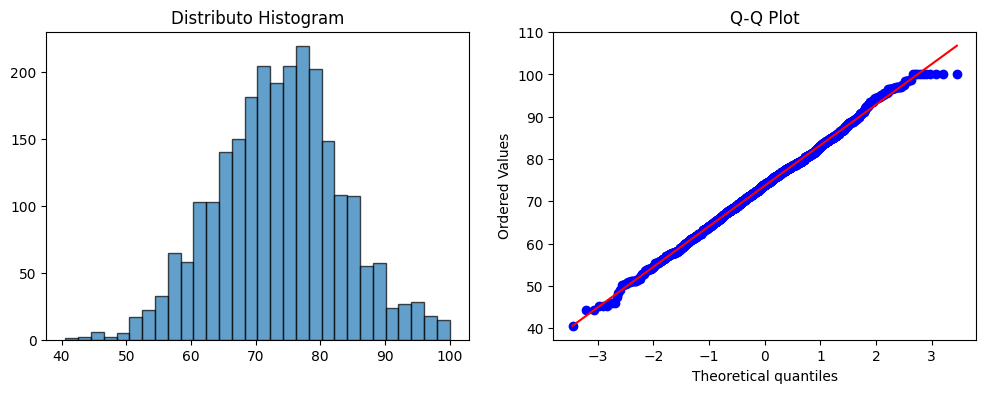

In [201]:
for category in categories:
    print(category)

    stat, p_value = stats.kstest(aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == category]['memory_score'], 'norm', args=(aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == category]['memory_score'].mean(), aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == category]['memory_score'].std()))
    print(f"Kolmogorov-Smirnov test: statistic={stat:.4f}, p-value={p_value:.4f}")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == category]['memory_score'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].set_title('Distributo Histogram')
    stats.probplot(aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == category]['memory_score'], dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot')
    plt.show()

As we can asses there may be serious problem with `Healthy` group because we have what appears to be a seriour data loss caused by ommiting large quantity of healthy partisipants' data. Kolmogorov-Smirnov tests shows that the group has severly damaged distribution of `memory_score`. Thus the anova results may be unreliable for first group the most. That also means that the model may be biased because of the `healthy` undersampling.

Nevertheless, we will make comparisions using anova. Anova method is forgiving for distributions like in `At-risk`, so no additional transformations will be applied

In [206]:
model = ols('memory_score ~ C(aging_outcome_cat)', data=aging_outcome_w_ms_df).fit()
print(model.summary2())

                          Results: Ordinary least squares
Model:                    OLS                   Adj. R-squared:          0.250     
Dependent Variable:       memory_score          AIC:                     54892.4545
Date:                     2025-12-09 14:39      BIC:                     54913.2177
No. Observations:         7488                  Log-Likelihood:          -27443.   
Df Model:                 2                     F-statistic:             1251.     
Df Residuals:             7485                  Prob (F-statistic):      0.00      
R-squared:                0.251                 Scale:                   89.340    
-----------------------------------------------------------------------------------
                                 Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------------------------
Intercept                        86.6527   0.1892 458.0179 0.0000  86.2819  87.0236
C(aging_outcome_ca

In [207]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


/var/folders/3k/2g_xrgp509qd4562wzk378jc0000gp/T/ipykernel_76217/4292181977.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title_text = f'Memory Score by Age Group\nANOVA: F({int(anova_table["df"][0])},{int(anova_table["df"][1])}) = {anova_table["F"][0]:.2f}, p = {anova_table["PR(>F)"][0]:.4f}'


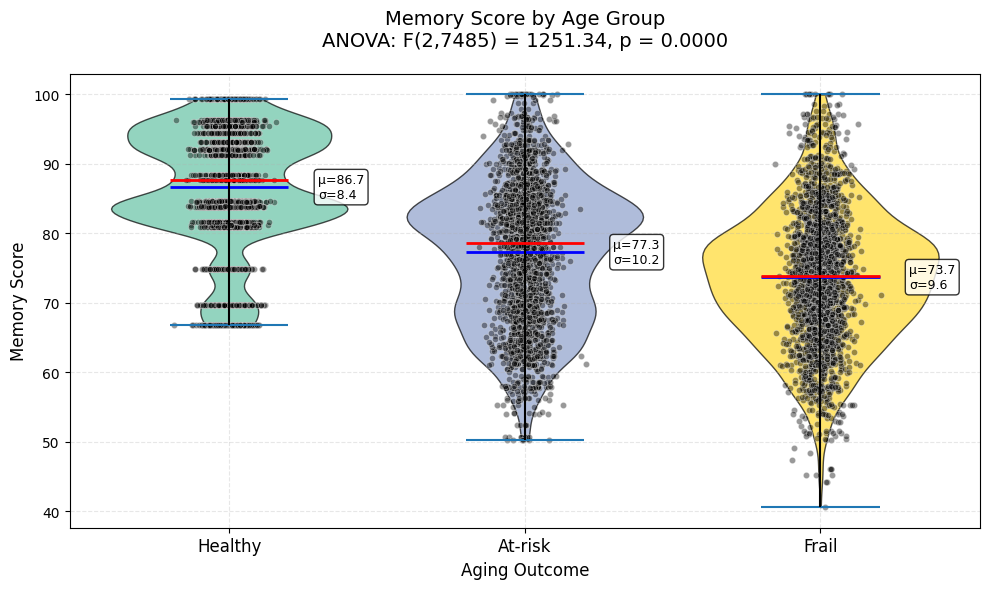

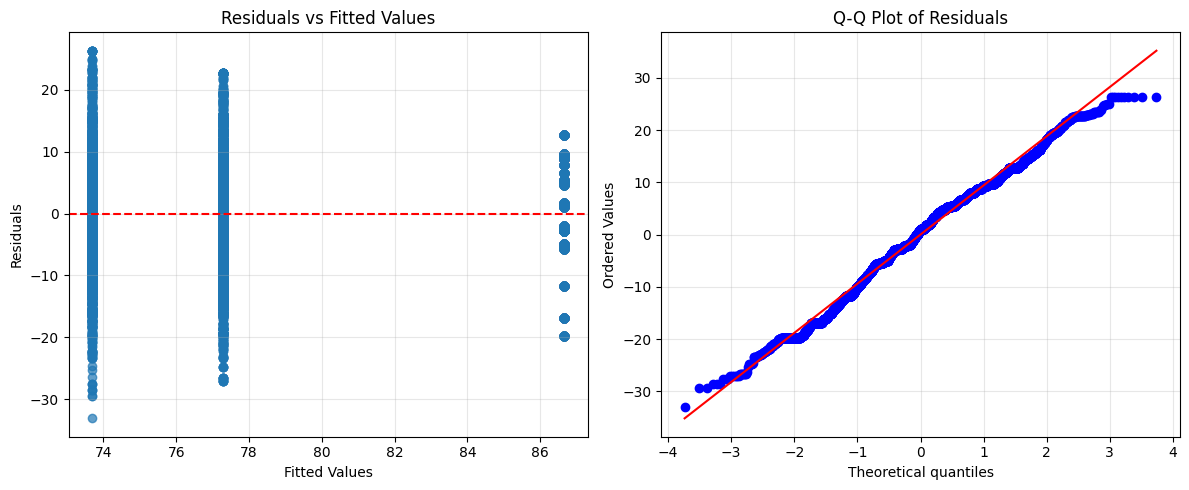

/var/folders/3k/2g_xrgp509qd4562wzk378jc0000gp/T/ipykernel_76217/4292181977.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:



POST-HOC TESTS (Tukey HSD)
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj  lower   upper  reject
-----------------------------------------------------
At-risk   Frail  -3.5964   0.0 -4.2236 -2.9692   True
At-risk Healthy   9.3672   0.0    8.74  9.9944   True
  Frail Healthy  12.9636   0.0 12.3365 13.5908   True
-----------------------------------------------------


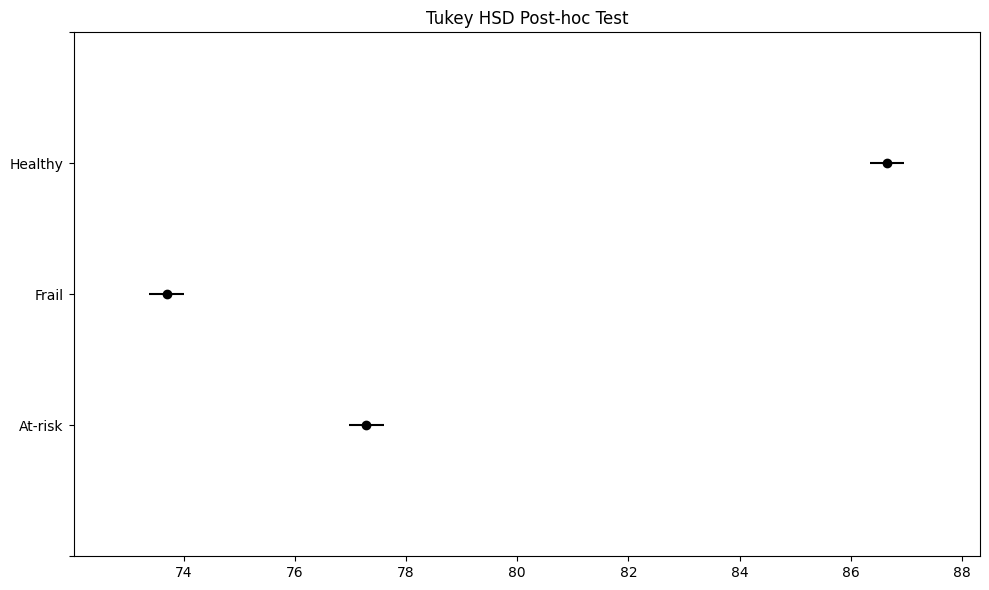

In [211]:
fig, ax = plt.subplots(figsize=(10, 6))
violins = ax.violinplot([aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == cat]['memory_score'] for cat in categories], 
                        showmeans=True, showmedians=True, widths=0.8)

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(plt.cm.Set2(i/len(categories)))
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    pc.set_linewidth(1)
    
violins['cmedians'].set_color('red')
violins['cmedians'].set_linewidth(2)
violins['cmeans'].set_color('blue')
violins['cmeans'].set_linewidth(2)
violins['cbars'].set_color('black')
violins['cbars'].set_linewidth(1.5)

for i, cat in enumerate(categories):
    y_data = aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == cat]['memory_score'].values
    x_data = np.random.normal(i+1, 0.05, size=len(y_data))  # Small jitter
    ax.scatter(x_data, y_data, alpha=0.4, color='black', s=20, edgecolors='white', linewidth=0.5)

for i, cat in enumerate(categories):
    group_data = aging_outcome_w_ms_df[aging_outcome_w_ms_df['aging_outcome'] == cat]['memory_score']
    mean_val = group_data.mean()
    std_val = group_data.std()
    ax.text(i+1.3, mean_val, f'μ={mean_val:.1f}\nσ={std_val:.1f}', 
            fontsize=9, va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xticks(range(1, len(categories) + 1))
ax.set_xticklabels(categories, fontsize=12)
ax.set_xlabel('Aging Outcome', fontsize=12)
ax.set_ylabel('Memory Score', fontsize=12)
ax.set_title('Memory Score Distribution by Age Group (Violin Plot)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

title_text = f'Memory Score by Age Group\nANOVA: F({int(anova_table["df"][0])},{int(anova_table["df"][1])}) = {anova_table["F"][0]:.2f}, p = {anova_table["PR(>F)"][0]:.4f}'
ax.set_title(title_text, fontsize=14, pad=20)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(model.fittedvalues, model.resid, alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(True, alpha=0.3)
stats.probplot(model.resid, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


if anova_table['PR(>F)'][0] < 0.05:
    print("\n" + "="*50)
    print("POST-HOC TESTS (Tukey HSD)")
    print("="*50)
    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    
    tukey = pairwise_tukeyhsd(endog=aging_outcome_w_ms_df['memory_score'],
                             groups=aging_outcome_w_ms_df['aging_outcome'],
                             alpha=0.05)
    print(tukey)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    tukey.plot_simultaneous(ax=ax)
    ax.set_title('Tukey HSD Post-hoc Test')
    plt.tight_layout()
    plt.show()

In [216]:
# 6. Group summary statistics
print("\n" + "="*76)
print("GROUP SUMMARY STATISTICS")
print("="*76)

summary_df = aging_outcome_w_ms_df.groupby('aging_outcome')['memory_score'].agg([
    ('N', 'count'),
    ('Mean', 'mean'),
    ('SD', 'std'),
    ('SE', lambda x: np.std(x, ddof=1)/np.sqrt(len(x))),
    ('25%', lambda x: np.percentile(x, 25)),
    ('Median', 'median'),
    ('75%', lambda x: np.percentile(x, 75)),
    ('Min', 'min'),
    ('Max', 'max')
]).round(2)

print(summary_df)


GROUP SUMMARY STATISTICS
                  N   Mean     SD    SE    25%  Median    75%    Min     Max
aging_outcome                                                               
At-risk        2496  77.29  10.25  0.21  68.98   78.59  84.48  50.18  100.00
Frail          2496  73.69   9.58  0.19  67.40   73.89  79.62  40.58  100.00
Healthy        2496  86.65   8.44  0.17  81.67   87.70  93.19  66.79   99.34


The analysis of variance revealed a statistically significant effect in `aging outcome` category on memory performance. Post-hoc Tukey HSD tests with family-wise error rate control showed that all pairwise comparisons between groups were significant. `Healthy` participants demonstrated the highest mean memory score (M = 86.65, SD = 8.44), followed by the `at-risk` group (M = 77.29, SD = 10.25), with the `frail` group showing the lowest performance (M = 73.69, SD = 9.58). Both `at-risk` (mean difference = 9.37, 95% CI [8.74, 9.99]) and `frail` (mean difference = 12.96, 95% CI [12.34, 13.59]) groups scored significantly lower than `healthy` participants. Additionally, `frail` participants performed significantly worse than `at-risk` participants (mean difference = -3.60, 95% CI [-4.22, -2.97]), indicating a graded relationship where increasing frailty corresponds to progressively worse memory function.

Because `At-risk` and `frial` have most normal distributions we can conclude that significant difference between memory scores is very much real.


Let us then examine the differences in `education_years` for different memory scores. In order to do that we will employ ANOVA test. Before that we need to assess the distributions

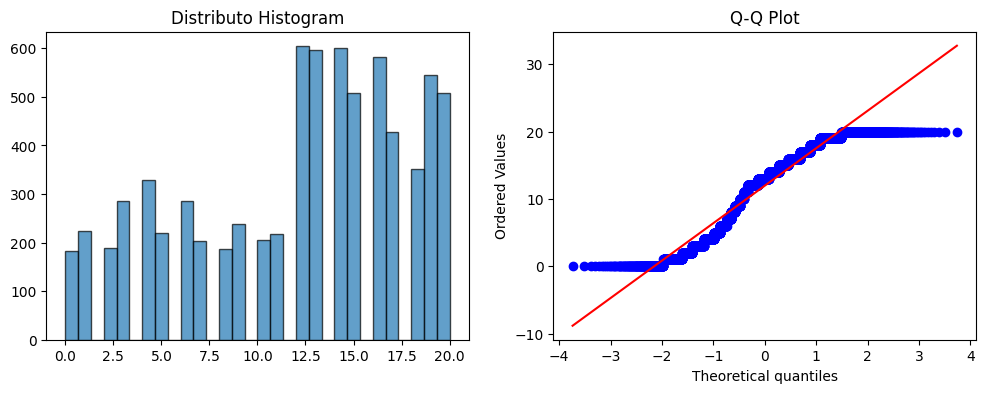

In [232]:
education_years_w_ms_df = df[['aging_outcome', 'aging_outcome_int', 'education_years']].to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(education_years_w_ms_df['education_years'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distributo Histogram')
stats.probplot(education_years_w_ms_df['education_years'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
plt.show()

In [233]:
df.group_by('aging_outcome').agg(pl.col('education_years').mean().alias('memory score mean'))

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


As we can see we have to resort to non-prarmetric tests. In order to substitude ANOVE we opted to `Kruskal-Wallis test`

In [236]:
def kruskal_wallis_analysis(df, group_col, target_col, 
                                 p_adjust_method='holm', 
                                 alpha=0.05, 
                                 verbose=True):
    groups = df[group_col].unique()
    
    group_data = []
    group_labels = []
    
    for group in groups:
        group_scores = df[df[group_col] == group][target_col].dropna()
        group_data.append(group_scores)
        group_labels.append(str(group))
        
        if verbose:
            print(f"Group '{group}': n = {len(group_scores)}, " 
                  f"Median = {np.median(group_scores):.2f}, "
                  f"Mean = {np.mean(group_scores):.2f}")
    
    # 3. Kruskal-Wallis test
    kw_stat, kw_p = stats.kruskal(*group_data)
    
    # 4. Calculate epsilon-squared effect size
    n_total = sum(len(g) for g in group_data)
    k = len(groups)
    epsilon2 = (kw_stat - k + 1) / (n_total - k)
    
    # 5. Determine significance
    is_significant = kw_p < alpha
    
    # 6. Dunn's post-hoc test if significant
    dunn_results = None
    pairwise_effects = None
    
    if is_significant:
        dunn_results = sp.posthoc_dunn(
            df, 
            val_col=target_col, 
            group_col=group_col,
            p_adjust=p_adjust_method
        )
        
        # Optional: Calculate Cliff's delta for pairwise effect sizes
        pairwise_effects = {}
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                group_i = groups[i]
                group_j = groups[j]
                
                data_i = df[df[group_col] == group_i][target_col].values
                data_j = df[df[group_col] == group_j][target_col].values
                
                # Cliff's delta (non-parametric effect size)
                n_i = len(data_i)
                n_j = len(data_j)
                
                # Calculate dominance matrix
                wins = 0
                losses = 0
                ties = 0
                
                for x in data_i:
                    for y in data_j:
                        if x > y:
                            wins += 1
                        elif x < y:
                            losses += 1
                        else:
                            ties += 1
                
                delta = (wins - losses) / (n_i * n_j)
                
                # Interpretation
                magnitude = "negligible"
                if abs(delta) >= 0.147:
                    magnitude = "small"
                if abs(delta) >= 0.33:
                    magnitude = "medium"
                if abs(delta) >= 0.474:
                    magnitude = "large"
                
                pairwise_effects[f"{group_i}_vs_{group_j}"] = {
                    "cliffs_delta": delta,
                    "magnitude": magnitude,
                    "wins": wins,
                    "losses": losses,
                    "ties": ties
                }
    
    print(f"\nKruskal-Wallis Test:")
    print(f"  H-statistic = {kw_stat:.3f}")
    print(f"  p-value = {kw_p:.4f}")
    print(f"  {'Significant' if is_significant else 'Not significant'} at α = {alpha}")
    
    print(f"\nEffect Size:")
    print(f"  Epsilon-squared (ε²) = {epsilon2:.3f}")
    
    # Interpret epsilon-squared
    eps_magnitude = "small"
    if epsilon2 >= 0.14:
        eps_magnitude = "large"
    elif epsilon2 >= 0.06:
        eps_magnitude = "medium"
    print(f"  Interpretation: {eps_magnitude} effect")
    
    print(f"\nSample Sizes:")
    print(f"  Total N = {n_total}")
    for group, data in zip(group_labels, group_data):
        print(f"  {group}: n = {len(data)}")
    
    if is_significant and dunn_results is not None:
        print(f"\nDunn's Post-Hoc Tests (adjusted with {p_adjust_method}):")
        print(dunn_results.round(4))
        
        print(f"\nPairwise Comparisons (α = {alpha}):")
        for i in range(len(groups)):
            for j in range(i + 1, len(groups)):
                p_val = dunn_results.iloc[i, j]
                is_sig = p_val < alpha
                symbol = "***" if is_sig else "ns"
                print(f"  {groups[i]} vs {groups[j]}: p = {p_val:.4f} {symbol}")
        
        if pairwise_effects:
            print(f"\nCliff's Delta Effect Sizes:")
            for comparison, effect in pairwise_effects.items():
                delta = effect['cliffs_delta']
                magnitude = effect['magnitude']
                direction = ">" if delta > 0 else "<"
                groups_in_comp = comparison.split('_vs_')
                group1, group2 = groups_in_comp[0], groups_in_comp[1]
                print(f"  {group1} {direction} {group2}: δ = {delta:.3f} ({magnitude})")

In [237]:
kruskal_wallis_analysis(education_years_w_ms_df, group_col='aging_outcome', target_col='education_years')

Group 'At-risk': n = 2496, Median = 13.00, Mean = 12.19
Group 'Healthy': n = 2496, Median = 15.00, Mean = 14.46
Group 'Frail': n = 2496, Median = 9.00, Mean = 9.23

Kruskal-Wallis Test:
  H-statistic = 953.738
  p-value = 0.0000
  Significant at α = 0.05

Effect Size:
  Epsilon-squared (ε²) = 0.127
  Interpretation: medium effect

Sample Sizes:
  Total N = 7488
  At-risk: n = 2496
  Healthy: n = 2496
  Frail: n = 2496

Dunn's Post-Hoc Tests (adjusted with holm):
         At-risk  Frail  Healthy
At-risk      1.0    0.0      0.0
Frail        0.0    1.0      0.0
Healthy      0.0    0.0      1.0

Pairwise Comparisons (α = 0.05):
  At-risk vs Healthy: p = 0.0000 ***
  At-risk vs Frail: p = 0.0000 ***
  Healthy vs Frail: p = 0.0000 ***

Cliff's Delta Effect Sizes:
  At-risk < Healthy: δ = -0.201 (small)
  At-risk > Frail: δ = 0.286 (small)
  Healthy > Frail: δ = 0.509 (large)


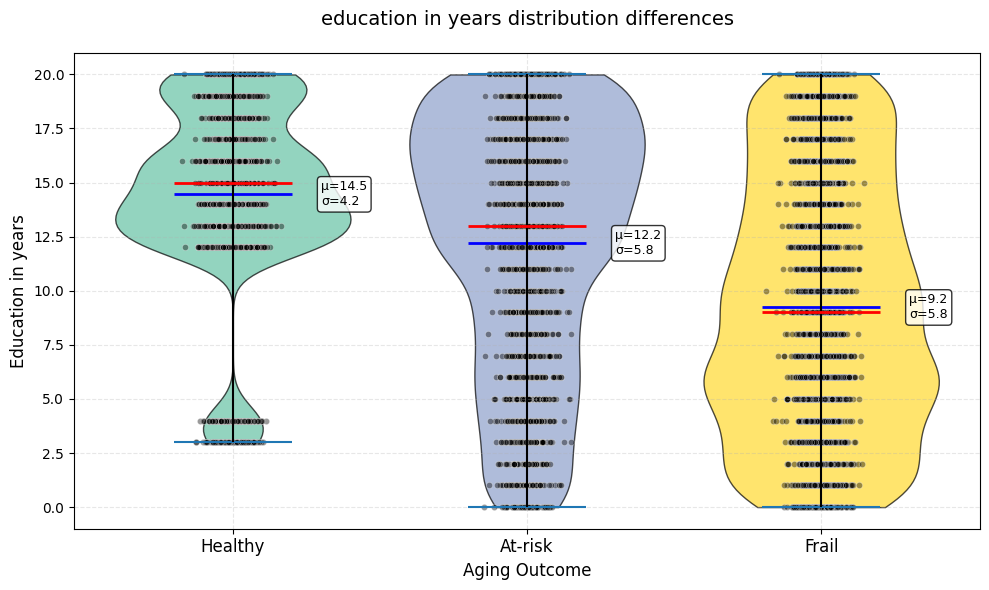

In [240]:
fig, ax = plt.subplots(figsize=(10, 6))
violins = ax.violinplot([education_years_w_ms_df[education_years_w_ms_df['aging_outcome'] == cat]['education_years'] for cat in categories], 
                        showmeans=True, showmedians=True, widths=0.8)

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(plt.cm.Set2(i/len(categories)))
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    pc.set_linewidth(1)
    
violins['cmedians'].set_color('red')
violins['cmedians'].set_linewidth(2)
violins['cmeans'].set_color('blue')
violins['cmeans'].set_linewidth(2)
violins['cbars'].set_color('black')
violins['cbars'].set_linewidth(1.5)

for i, cat in enumerate(categories):
    y_data = education_years_w_ms_df[education_years_w_ms_df['aging_outcome'] == cat]['education_years'].values
    x_data = np.random.normal(i+1, 0.05, size=len(y_data))  # Small jitter
    ax.scatter(x_data, y_data, alpha=0.4, color='black', s=20, edgecolors='white', linewidth=0.5)

for i, cat in enumerate(categories):
    group_data = education_years_w_ms_df[education_years_w_ms_df['aging_outcome'] == cat]['education_years']
    mean_val = group_data.mean()
    std_val = group_data.std()
    ax.text(i+1.3, mean_val, f'μ={mean_val:.1f}\nσ={std_val:.1f}', 
            fontsize=9, va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xticks(range(1, len(categories) + 1))
ax.set_xticklabels(categories, fontsize=12)
ax.set_xlabel('Aging Outcome', fontsize=12)
ax.set_ylabel('Education in years', fontsize=12)
ax.set_title('Memory Score Distribution by Age Group (Violin Plot)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

ax.set_title('education in years distribution differences', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

As we can see in Kruskal-Wallis test: there's statistically significant differences in scores across aging outcome categories (H = 953.74, p < .001), with a medium overall effect size (ε² = 0.127). Post-hoc Dunn's tests with Holm adjustment confirmed all pairwise comparisons were significant (all p < .001). Healthy participants demonstrated the highest scores (M = 14.46, Mdn = 15.00), followed by at-risk participants (M = 12.19, Mdn = 13.00), while frail participants scored the lowest (M = 9.23, Mdn = 9.00). Effect size analysis using Cliff's delta indicated a large difference between healthy and frail participants (δ = 0.509), with small differences between healthy and at-risk participants (δ = -0.201) and between at-risk and frail participants (δ = 0.286). The results demonstrate a clear graded relationship where increasing frailty corresponds to progressively lower scores across all three groups.


Let us then examine the differences in `chronic_conditions` for different memory scores. In order to do that we will employ ANOVA test. Before that we need to assess the distributions. In this case we have the same situation as in `education in years`

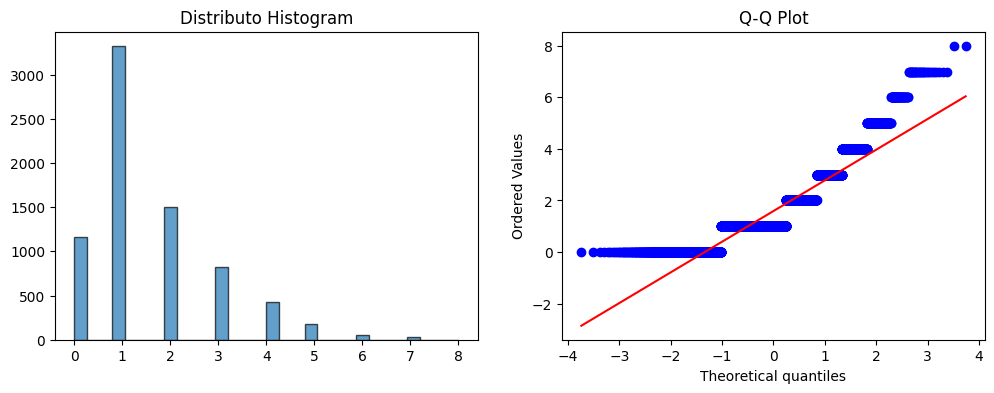

In [246]:
chronic_conditions_w_ms_df = df[['aging_outcome', 'aging_outcome_int', 'chronic_conditions']].to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(chronic_conditions_w_ms_df['chronic_conditions'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distributo Histogram')
stats.probplot(chronic_conditions_w_ms_df['chronic_conditions'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
plt.show()

In [243]:
df.group_by('aging_outcome').agg(pl.col('chronic_conditions').mean().alias('chronic conditions mean'))

Loading ITables v2.4.5 from the init_notebook_mode cell... (need help?)


In [244]:
kruskal_wallis_analysis(chronic_conditions_w_ms_df, group_col='aging_outcome', target_col='chronic_conditions')

Group 'At-risk': n = 2496, Median = 1.00, Mean = 1.57
Group 'Healthy': n = 2496, Median = 1.00, Mean = 0.91
Group 'Frail': n = 2496, Median = 2.00, Mean = 2.29

Kruskal-Wallis Test:
  H-statistic = 1526.740
  p-value = 0.0000
  Significant at α = 0.05

Effect Size:
  Epsilon-squared (ε²) = 0.204
  Interpretation: large effect

Sample Sizes:
  Total N = 7488
  At-risk: n = 2496
  Healthy: n = 2496
  Frail: n = 2496

Dunn's Post-Hoc Tests (adjusted with holm):
         At-risk  Frail  Healthy
At-risk      1.0    0.0      0.0
Frail        0.0    1.0      0.0
Healthy      0.0    0.0      1.0

Pairwise Comparisons (α = 0.05):
  At-risk vs Healthy: p = 0.0000 ***
  At-risk vs Frail: p = 0.0000 ***
  Healthy vs Frail: p = 0.0000 ***

Cliff's Delta Effect Sizes:
  At-risk > Healthy: δ = 0.268 (small)
  At-risk < Frail: δ = -0.312 (small)
  Healthy < Frail: δ = -0.618 (large)


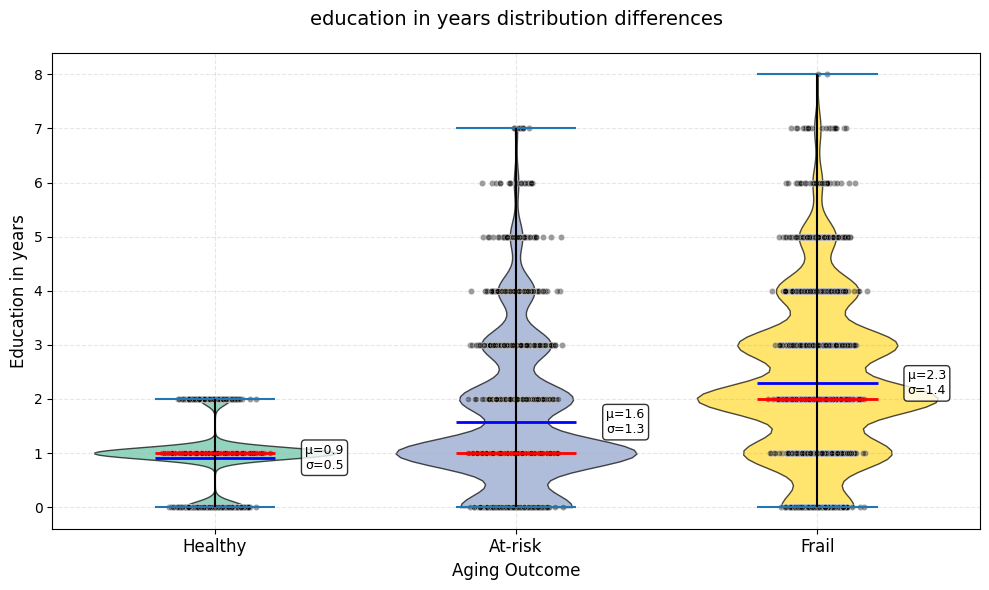

In [245]:
fig, ax = plt.subplots(figsize=(10, 6))
violins = ax.violinplot([chronic_conditions_w_ms_df[chronic_conditions_w_ms_df['aging_outcome'] == cat]['chronic_conditions'] for cat in categories], 
                        showmeans=True, showmedians=True, widths=0.8)

for i, pc in enumerate(violins['bodies']):
    pc.set_facecolor(plt.cm.Set2(i/len(categories)))
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)
    pc.set_linewidth(1)
    
violins['cmedians'].set_color('red')
violins['cmedians'].set_linewidth(2)
violins['cmeans'].set_color('blue')
violins['cmeans'].set_linewidth(2)
violins['cbars'].set_color('black')
violins['cbars'].set_linewidth(1.5)

for i, cat in enumerate(categories):
    y_data = chronic_conditions_w_ms_df[chronic_conditions_w_ms_df['aging_outcome'] == cat]['chronic_conditions'].values
    x_data = np.random.normal(i+1, 0.05, size=len(y_data))  # Small jitter
    ax.scatter(x_data, y_data, alpha=0.4, color='black', s=20, edgecolors='white', linewidth=0.5)

for i, cat in enumerate(categories):
    group_data = chronic_conditions_w_ms_df[chronic_conditions_w_ms_df['aging_outcome'] == cat]['chronic_conditions']
    mean_val = group_data.mean()
    std_val = group_data.std()
    ax.text(i+1.3, mean_val, f'μ={mean_val:.1f}\nσ={std_val:.1f}', 
            fontsize=9, va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xticks(range(1, len(categories) + 1))
ax.set_xticklabels(categories, fontsize=12)
ax.set_xlabel('Aging Outcome', fontsize=12)
ax.set_ylabel('Education in years', fontsize=12)
ax.set_title('Memory Score Distribution by Age Group (Violin Plot)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

ax.set_title('education in years distribution differences', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

Based on Kruskal-Wallis test, there was a statistically significant difference in scores across the three aging outcome categories (H = 1526.74, p < .001), with a large overall effect size (ε² = 0.204). Post-hoc comparisons using Dunn's test with Holm adjustment revealed significant differences between all group pairs (all p < .001). Frail participants reported the highest scores (M = 2.29, Mdn = 2.00), followed by at-risk participants (M = 1.57, Mdn = 1.00), while healthy participants reported the lowest scores (M = 0.91, Mdn = 1.00). Effect size analysis using Cliff's delta indicated a large negative effect between healthy and frail participants (δ = -0.618), showing that frail participants had substantially higher scores than their healthy counterparts. Smaller effects were observed between at-risk and healthy participants (δ = 0.268) and between at-risk and frail participants (δ = -0.312). The results demonstrate a graded relationship where increasing frailty status is associated with progressively higher scores across all three groups.

# Conclusions

`CatBoostClassifier` identified `memory_score`, `education_years`, `chronic_conditions`, and `physical_activity` as the most important predictive factors for aging outcomes, while gender and income_level were among the least important. It is important to note a significant caveat: the analysis revealed a likely serious undersampling of data from the `Healthy` \ group, which has resulted in a damaged distribution for the key memory_score variable. This data loss introduces potential bias into the model and suggests that ANOVA results for the `Healthy` group should be interpreted with caution.

Despite this limitation, the statistical comparisons revealed strong, graded relationships between aging outcomes and the key factors. Analysis of variance showed that `memory_scor` significantly declined across groups, with the `Healthy` group performing best, followed by the `At-risk` and then `Frail groups`, with all pairwise differences being statistically significant. Similarly, a clear downward trend in `education_year`s was observed from the `Healthy` to the Frail group. Conversely, the number of `chronic_conditions` showed a significant upward trend, with the `Frail` group reporting the highest burden.